In [124]:
import ast
import networkx as nx
import astunparse

In [125]:
class GraphCreator(ast.NodeTransformer):
    def __init__(self, graph):
        self.__graph = graph

    def __add_body(self, node, body):
        self.__graph.add_node(id(body), label='body', fillcolor='#db5151', style='filled', shape='circle')
        self.__graph.add_edge(id(node), id(body))

        for child_node in body:
            self.visit(child_node)
            self.__graph.add_edge(id(body), id(child_node))

    def __add_orelse(self, node, orelse):
        self.__graph.add_node(id(orelse), label='orelse', fillcolor='#d05171', style='filled', shape='circle')
        self.__graph.add_edge(id(node), id(orelse))

        for child_node in orelse:
            self.visit(child_node)
            self.__graph.add_edge(id(orelse), id(child_node))


    def __add_args(self, node, args):
        self.__graph.add_node(id(args), label='args', shape='s', fillcolor='#5c89fa', style='filled')
        self.__graph.add_edge(id(node), id(args))

        for arg in args:
            self.visit(arg)
            self.__graph.add_edge(id(args), id(arg))

    def visit_FunctionDef(self, node: ast.FunctionDef):
        self.__graph.add_node(id(node), label=f'function: {node.name}', shape='s')

        self.__add_body(node, node.body)

        self.__graph.add_node(id(node.args), label=f'args', shape='s', fillcolor='#5c89fa', style='filled')
        self.__graph.add_edge(id(node), id(node.args))

        for arg in node.args.args:
            self.__graph.add_node(id(arg), label=f'{arg.arg}', shape='s', fillcolor='#faf55c', style='filled')
            self.__graph.add_edge(id(node.args), id(arg))

        return node

    def visit_Assign(self, node: ast.Assign):
        self.__graph.add_node(id(node), label=astunparse.unparse(node), shape='s', fillcolor='#2fe0ab', style='filled')
        return node

    def visit_Num(self, node: ast.Num):
        self.__graph.add_node(id(node), label=astunparse.unparse(node), shape='s', fillcolor='#faf55c', style='filled')

        return node

    def visit_Name(self, node: ast.Name):
        self.__graph.add_node(id(node), label=node.id, shape='s', fillcolor='#faf55c', style='filled')

        return node

    def visit_Call(self, node: ast.Call):
        self.__graph.add_node(id(node), label=f'call', shape='s', fillcolor='#aae858', style='filled')

        self.__graph.add_node(id(node.func), label=astunparse.unparse(node.func), shape='s', fillcolor='#cf0000c7', style='filled')
        self.__graph.add_edge(id(node), id(node.func), label='func')

        self.__add_args(node, node.args)

        return node

    def visit_If(self, node: ast.If):
        self.__graph.add_node(id(node), label='if', shape='s', fillcolor='#0303037a', style='filled')

        self.visit(node.test)
        self.__graph.add_edge(id(node), id(node.test))

        self.__add_body(node, node.body)

        self.__add_orelse(node, node.orelse)

        return node

    def visit_For(self, node: ast.For):
        self.__graph.add_node(id(node), label='for', shape='s', fillcolor='#0303037a', style='filled')

        self.visit(node.target)
        self.__graph.add_edge(id(node), id(node.target), label='target')

        self.visit(node.iter)
        self.__graph.add_edge(id(node), id(node.iter), label='iter')

        self.__add_body(node, node.body)

        return node

    def visit_Expr(self, node: ast.Expr):
        self.__graph.add_node(id(node), label='expression', shape='s', fillcolor='#cf6e00c7', style='filled')

        self.visit(node.value)
        self.__graph.add_edge(id(node), id(node.value), label='value')

        return node

    def visit_BinOp(self, node: ast.BinOp):
        self.__graph.add_node(id(node), label='result', shape='s', fillcolor='#e87a58', style='filled')

        def get_operation(func): # ast.Sub, ast.Add and strings are singletons, so...
            class Operation:
                def __init__(self, operation):
                    self.__operation = operation

                def __str__(self):
                    return self.__operation

            if isinstance(func, ast.Add):
                return Operation('+')
            else:
                return Operation('-')

        operation = get_operation(node.op)
        self.__graph.add_node(id(operation), label=operation, shape='s', fillcolor='#fac55c', style='filled')
        self.__graph.add_edge(id(node), id(operation))

        self.visit(node.left)
        self.__graph.add_edge(id(operation), id(node.left))

        self.visit(node.right)
        self.__graph.add_edge(id(operation), id(node.right))

        return node

    def visit_Subscript(self, node: ast.Subscript):
        self.__graph.add_node(id(node), label='subscript', shape='s', fillcolor='#58bde8', style='filled')

        self.visit(node.value)
        self.__graph.add_edge(id(node), id(node.value), label='value')

        self.visit(node.slice)
        self.__graph.add_edge(id(node), id(node.slice), label='index')

        return node

    def visit_Index(self, node: ast.Index):
        self.__graph.add_node(id(node), label='index', shape='s', fillcolor='#436350af', style='filled')

        self.visit(node.value)
        self.__graph.add_edge(id(node), id(node.value))

        return node

    def visit_Slice(self, node: ast.Slice):
        self.__graph.add_node(id(node), label='slice', shape='s', fillcolor='#436350af', style='filled')

        if node.lower is not None:
            self.visit(node.lower)
            self.__graph.add_edge(id(node), id(node.lower), label='lower')

        if node.upper is not None:
            self.visit(node.upper)
            self.__graph.add_edge(id(node), id(node.upper), label='upper')

        if node.step is not None:
            self.visit(node.step)
            self.__graph.add_edge(id(node), id(node.upper), label='step')

        return node

    def visit_Return(self, node: ast.Return):
        self.__graph.add_node(id(node), label='return', shape='s', fillcolor='#866bb3c7', style='filled')

        self.visit(node.value)
        self.__graph.add_edge(id(node), id(node.value))

        return node

    def get_graph(self):
        return self.__graph

In [126]:
from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

In [127]:
def visualize(source):
    tree = ast.parse(source)
    g = GraphCreator(nx.DiGraph())
    tree = g.visit(tree)
    graph = nx.drawing.nx_pydot.to_pydot(g.get_graph())

    view_pydot(graph)

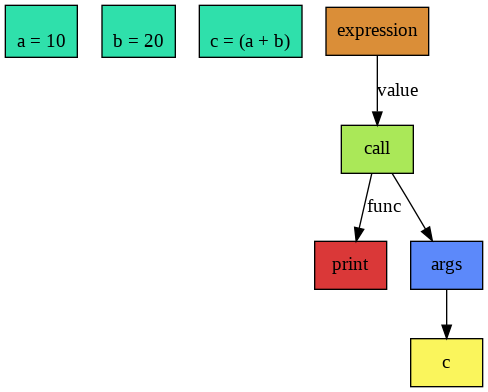

In [128]:
visualize(
"""
a = 10
b = 20
c = a + b
print(c)
"""
)

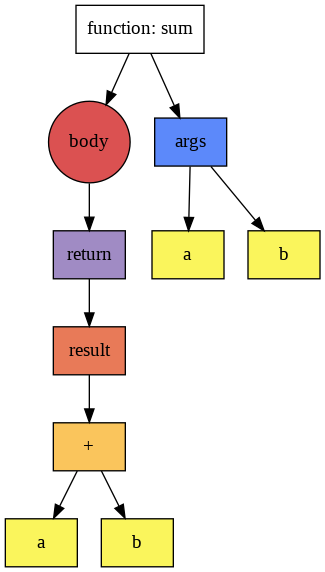

In [129]:
visualize(
"""
def sum(a, b):
    return a + b
"""
)

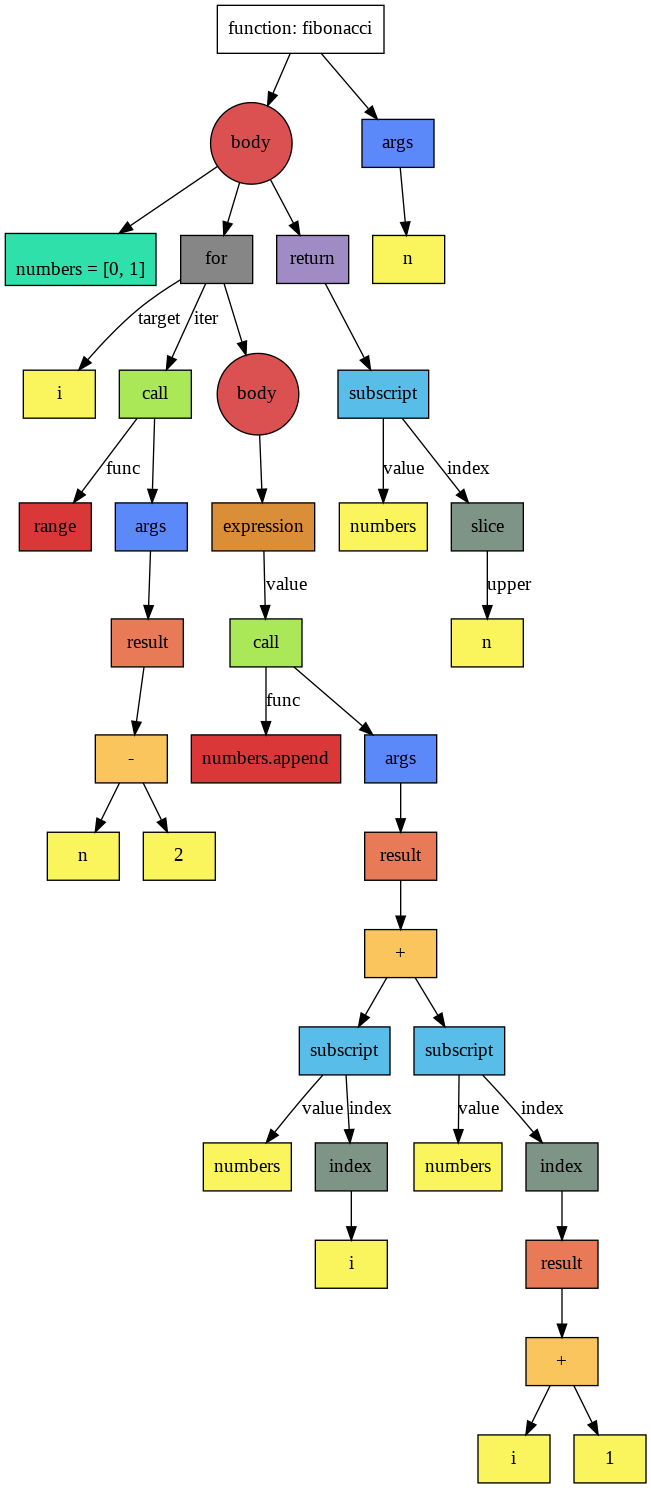

In [131]:
visualize(
"""
def fibonacci(n):
    numbers = [0, 1]
    for i in range(n - 2):
        numbers.append(numbers[i] + numbers[i + 1])
    return numbers[:n]
"""
)